In [1]:
#!pip install lightgbm

In [2]:
#LIBRARIES

import time
start_time = time.time()

#Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import itertools
from pylab import rcParams

import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline


from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [3]:
pd.set_option('display.max_columns', 10)

In [4]:
#DATASETS
X_train = pd.read_csv('X_train.csv',sep=';',decimal=',')
forecast_df = pd.read_csv('X_test.csv',sep=';',decimal=',')
Y_test = pd.read_csv('Y_test.csv',sep=';',decimal=',')
Y_train = pd.read_csv('Y_train.csv',sep=';',decimal=',')

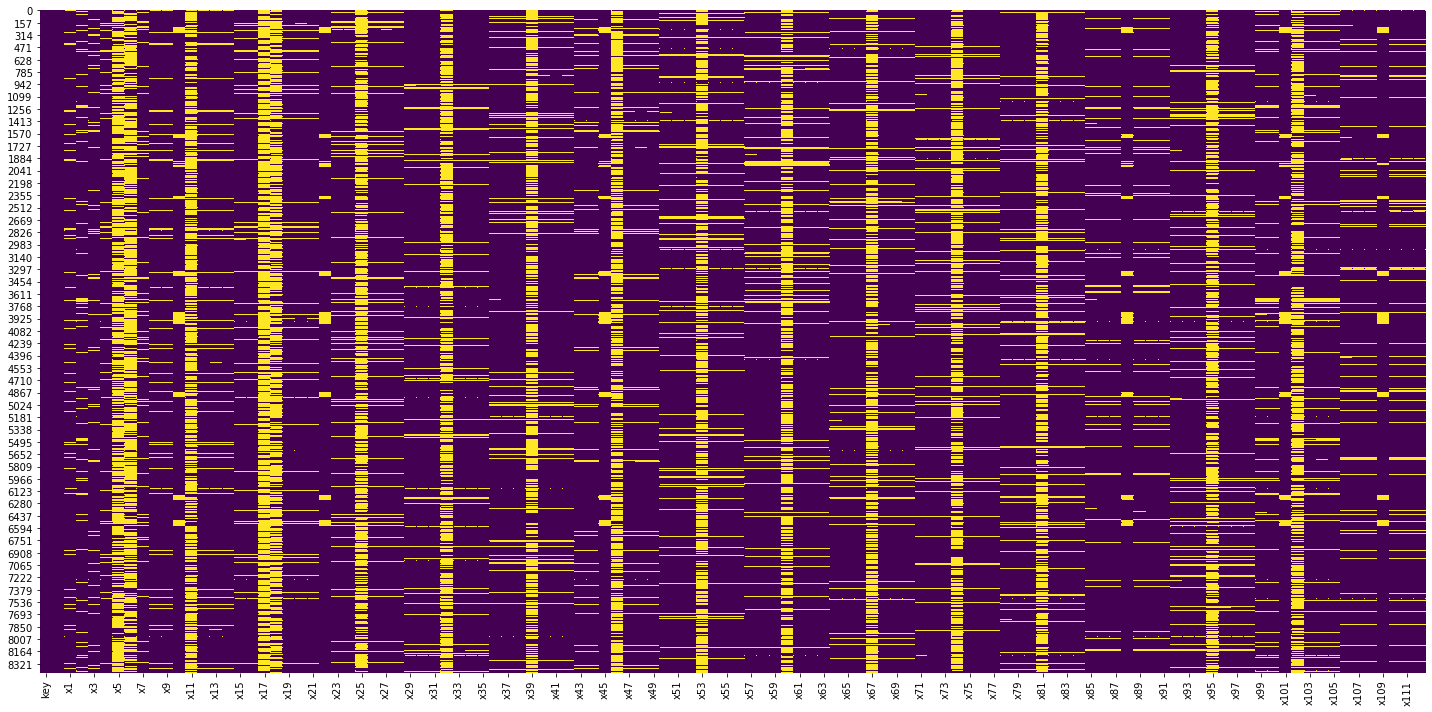

In [5]:
#VISUALIZATION OF MISSING VARIABLES

plt.figure(figsize=(20,10))
sns.heatmap(X_train.isna(),cbar=False,cmap='viridis')
plt.tight_layout()

In [6]:
pd.DataFrame((X_train.isna().sum()/8437)*100,columns=['missing_%'])

,missing_%
key,0.000000
date,0.000000
x1,7.550077
x2,7.633045
x3,7.585635
...,...
x108,7.348584
x109,7.490814
x110,7.313026
x111,7.348584


In [7]:
missing_df = pd.DataFrame((X_train.isna().sum()/8437)*100,columns=['missing_%'])

In [8]:
#IF VARIABLE HAS 25%> OF MISSING VALUES THAN X=1 , ELSE X=0
x = []
for i,item in missing_df.iterrows():
    if missing_df['missing_%'][i] >= 25:
        x.append(1)
    else:
        x.append(0)

In [9]:
#DATA PROCESSING; TAKING ONLY VARIABLES WHICH HAVE 25%> 
x = pd.DataFrame(x)
x = x.reset_index()

missing_df = missing_df.reset_index().reset_index()
missing_df = missing_df.rename(columns={'level_0':'index_2'})

x = x.rename(columns={'index':'index_2'})

new_missing = missing_df.merge(x,on='index_2')
new_missing = new_missing.drop(labels='index_2',axis=1)
new_missing = new_missing.rename(columns={0:'big'})

big_missing = new_missing[new_missing['big'] == 1 ]

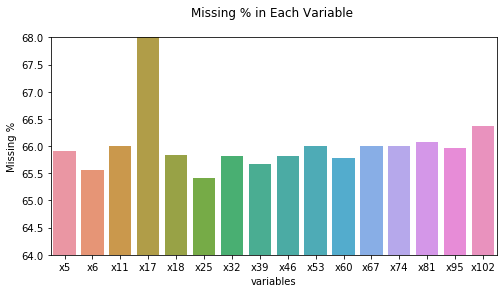

Note: that x17 has 75%> missing


In [10]:
#VISUALIZATION OF UPPER DATA PROCESSING; ALL VARIABLES WHICH HAVE >25% MISSING DATA ARE PRESENTED ON THE CHART, ALL OF THEM HAVE EVEN 60%> OF MISSING DATA WHICH IS TOO MUCH
plt.figure(figsize=(8,4))
sns.barplot(data=big_missing,x='index',y='missing_%')
plt.ylim((64,68))
plt.title('Missing % in Each Variable \n')
plt.xlabel('variables')
plt.ylabel('Missing %')
plt.show()
print('Note: that x17 has 75%> missing')

In [11]:
#DROPPING ALL THE VARIABLES BECAUSE ALL OF THEM HAVE >64% MISSING DATA 
X_train = X_train.drop(labels=["x5","x6","x11","x17","x18","x25","x32","x39","x46","x53","x60","x67"
                          ,"x74","x81","x95","x102"],axis=1)

In [12]:
################################## END OF MISSING VARIABLES ####################################

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EE2F675E08>]],
      dtype=object)

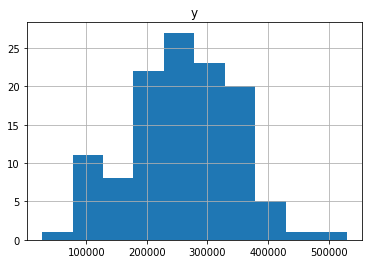

In [13]:
################################
#START OF CUSTOM METHOD OF IMPUTATION OF REST MISSING VARIABLES
################################
Y_train.groupby('key').sum().hist()

In [14]:
Y_train.groupby('key').sum().describe()

,y
count,119.000000
mean,256959.107246
std,86251.155060
min,27132.286640
25%,211112.718249
50%,256603.403155
75%,312621.330262
max,529516.124969


In [15]:
df = Y_train.groupby('key').sum()
df

,y
key,
683,206887.040721
894,212196.123194
2831,301246.523222
2835,360693.260697
4361,376849.859478
...,...
96037,211968.251959
97021,347668.677305
97392,329822.768407


In [16]:
#CREATING CATEGORICAL VARIABLE ACCORDING TO SUMMED PRODUCITON FOR EACH KEY, LATER I WILL IMPUT THE MISSING DATA BASED ON overall size OF THE PRODUCT
x = []
for i,item in df.iterrows():
    if df['y'][i] <= 211112.718249:
        x.append(1)
    elif df['y'][i] > 211112.718249 and df['y'][i] <= 256603.403155:
        x.append(2)
    elif df['y'][i] > 256603.403155 and df['y'][i] <= 312621.330262:
        x.append(3) 
    elif df['y'][i] > 312621.330262:
        x.append(4)

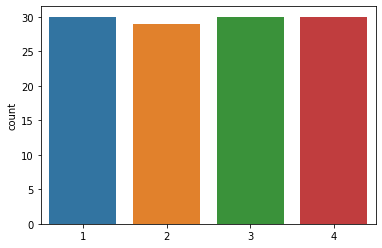

In [17]:
sns.countplot(x)

In [18]:
x = pd.DataFrame(x)
x = x.reset_index()

In [19]:
df = df.reset_index().reset_index()
df = df.merge(x,on='index').rename(columns={0:'Size_category'})
df = df[['key','Size_category']]

In [20]:
df_2 = df.copy()

In [21]:
X_train = X_train.merge(df,on='key')

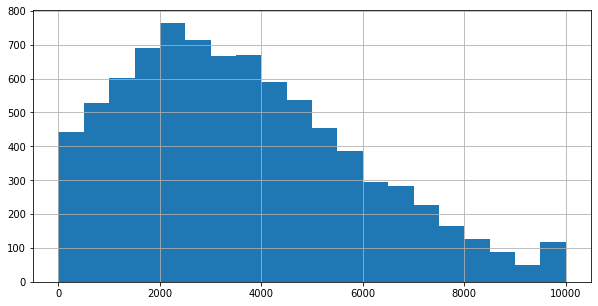

In [22]:
Y_train['y'].hist(bins=20,figsize=(10,5))

In [23]:
#Transforming date variable
X_train['date'] = pd.to_datetime(X_train['date'])
X_train['month'] = pd.DatetimeIndex(X_train['date']).month
X_train['year'] = pd.DatetimeIndex(X_train['date']).year

Y_train['date'] = pd.to_datetime(Y_train['date'])
Y_train['month'] = pd.DatetimeIndex(Y_train['date']).month
Y_train['year'] = pd.DatetimeIndex(Y_train['date']).year

In [24]:
X_train['year'].value_counts()

2017    1428
2016    1427
2015    1396
2014    1284
2013    1264
2012     924
2018     714
Name: year, dtype: int64

In [25]:
x = []
for i,item in X_train.iterrows():
    if X_train['year'][i] == 2012:
        x.append(0)
    elif X_train['year'][i] == 2013:
        x.append(12)
    elif X_train['year'][i] == 2014:
        x.append(24)
    elif X_train['year'][i] == 2015:
        x.append(36)
    elif X_train['year'][i] == 2016:
        x.append(48)   
    elif X_train['year'][i] == 2017:
        x.append(60)
    elif X_train['year'][i] == 2018:
        x.append(72)
    elif X_train['year'][i] == 2019:
        x.append(84)    
        
X_train['add'] = x
X_train['new_month'] = X_train['month'] + X_train['add']
X_train = X_train.drop(labels=['month','year','add','date'],axis=1)


In [26]:
#Filling missing variables based on size of the product
X_train = X_train.groupby('Size_category').transform(lambda x: x.fillna(x.mean()))

In [27]:
#Data processing
x = []
for i,item in Y_train.iterrows():
    if Y_train['year'][i] == 2012:
        x.append(0)
    elif Y_train['year'][i] == 2013:
        x.append(12)
    elif Y_train['year'][i] == 2014:
        x.append(24)
    elif Y_train['year'][i] == 2015:
        x.append(36)
    elif Y_train['year'][i] == 2016:
        x.append(48)   
    elif Y_train['year'][i] == 2017:
        x.append(60)
    elif Y_train['year'][i] == 2018:
        x.append(72)
    elif Y_train['year'][i] == 2019:
        x.append(84)    
        
Y_train['add'] = x
Y_train['new_month'] = Y_train['month'] + Y_train['add']
Y_train =  Y_train.fillna(Y_train.mean())
Y_train = Y_train[['key','y','new_month']]

In [28]:
Y_train['key'].value_counts()

8200     78
99444    78
61127    78
57423    78
37081    78
         ..
93876    42
66606    42
24248    34
59945    30
74523    29
Name: key, Length: 119, dtype: int64

In [29]:
def TimeSeries(key=683):
    """ Time series visualization by given product key, by default key=683"""
    Y_train[Y_train['key']==key].plot(kind='line',x='new_month',y='y',figsize=(12,6))

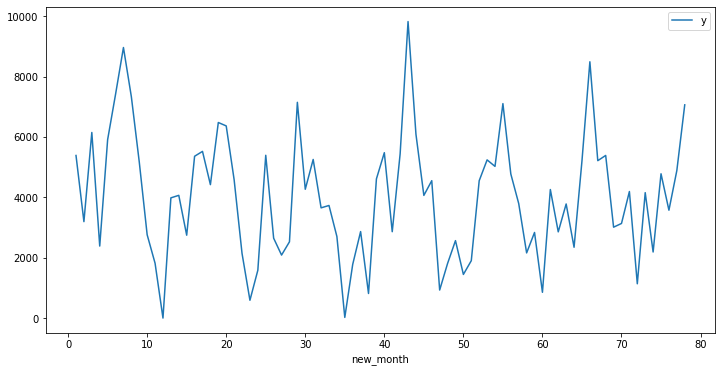

In [30]:
#Time series of product 8200
TimeSeries(8200)

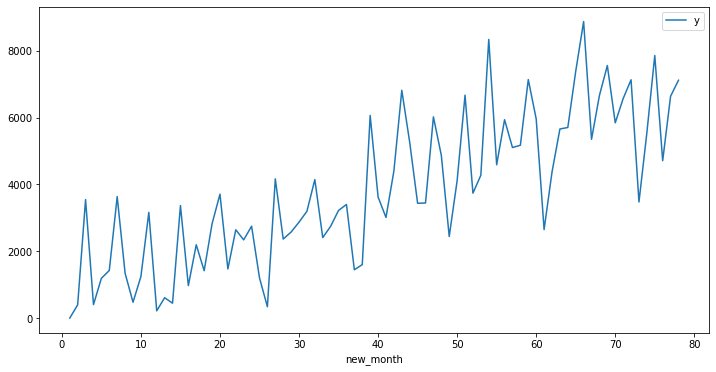

In [31]:
#Time series of product 99444
TimeSeries(99444)

In [32]:
###################################################

In [33]:
#Merging X_train + Y_train 
train = X_train.merge(Y_train)

In [34]:
#119 Unique products
train['key'].nunique()

119

In [35]:
#Our training dataset used to train / evaluate model performance, new_month are the months 
train

,key,x1,x2,x3,x4,...,x110,x111,x112,new_month,y
0,683,0.793085,0.000000,0.690346,0.000000,...,0.509713,216.851245,56.139906,1,1430.314968
1,683,0.000000,0.000686,0.590133,0.000000,...,2.526962,39.451960,7.172635,2,0.000000
2,683,0.000000,0.000000,0.000000,0.672651,...,0.242973,35.226264,50.614383,3,5088.531900
3,683,0.000000,0.000000,0.000000,0.022906,...,29.437773,5.591309,0.000000,4,2837.756051
4,683,0.000000,0.000000,0.000000,0.000000,...,0.125393,5.872891,0.000000,5,51.311689
...,...,...,...,...,...,...,...,...,...,...,...
8432,99444,0.000000,0.000000,0.000000,0.000000,...,-3.137605,1168.589213,64.490601,74,5543.532949
8433,99444,0.000000,0.000000,0.000000,0.000000,...,112.819870,541.409571,15.189098,75,7854.693921
8434,99444,1.205455,0.000000,6.719704,0.000000,...,1.532836,289.112965,1.863955,76,4707.540862
8435,99444,0.000000,0.000000,0.329129,0.000000,...,8.136763,6.391709,6.154658,77,6636.014977


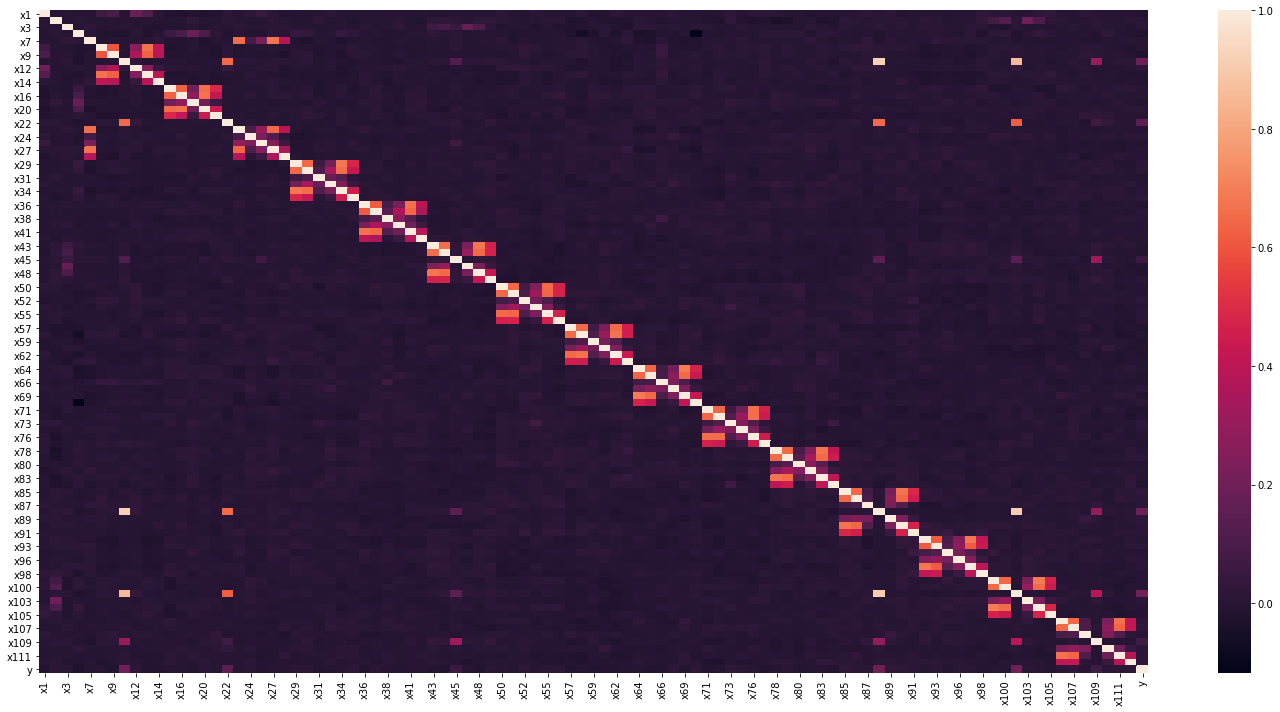

In [36]:
#Heatmap that shows that the variables which are close to each other e.g. (x7-x14) might be highly correlated due to be simmiliar, there are ~15 of those groups
#This might be good indicator that PCA is needed here or some cluster method on variables
plt.figure(figsize=(20,10))
sns.heatmap(train.drop(labels=['key','new_month'],axis=1).corr(),annot=False)
plt.tight_layout()

In [37]:
#Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
train_st = scaler.fit_transform(train.drop(labels=['key','new_month','y'],axis=1))

In [38]:
train_st

array([[ 0.2391502 , -0.18767311,  0.21061112, ..., -0.20768281,
        -0.20066996,  0.91228334],
       [-0.18674309, -0.18731001,  0.15363245, ..., -0.19841295,
        -0.35030259, -0.1234781 ],
       [-0.18674309, -0.18767311, -0.18190199, ..., -0.20890856,
        -0.35386688,  0.79540683],
       ...,
       [ 0.46059616, -0.18767311,  3.63875046, ..., -0.20298125,
        -0.13971869, -0.23576792],
       [-0.18674309, -0.18767311,  0.00523264, ..., -0.17263426,
        -0.37818823, -0.14501047],
       [-0.18674309, -0.18767311, -0.18190199, ...,  0.02132138,
        -0.19367859, -0.23775597]])

In [39]:
train_st = pd.DataFrame(train_st, columns=train.drop(labels=['key','new_month','y'],axis=1).columns)

In [40]:
#Scaled variables
train_st

,x1,x2,x3,x4,x7,...,x108,x109,x110,x111,x112
0,0.239150,-0.187673,0.210611,-0.172746,-0.165245,...,-0.213418,-0.175389,-0.207683,-0.200670,0.912283
1,-0.186743,-0.187310,0.153632,-0.172746,-0.323753,...,-0.213418,-0.190182,-0.198413,-0.350303,-0.123478
2,-0.186743,-0.187673,-0.181902,0.172482,-0.025916,...,-0.213418,-0.197593,-0.208909,-0.353867,0.795407
3,-0.186743,-0.187673,-0.181902,-0.160990,-0.295025,...,-0.213418,-0.182639,-0.074750,-0.378863,-0.275195
4,-0.186743,-0.187673,-0.181902,-0.172746,1.535326,...,-0.213418,-0.193782,-0.209449,-0.378626,-0.275195
...,...,...,...,...,...,...,...,...,...,...,...
8432,-0.186743,-0.187673,-0.181902,-0.172746,-0.328209,...,-0.213418,0.087036,-0.224443,0.602101,1.088918
8433,-0.186743,-0.187673,-0.181902,-0.172746,0.260939,...,-0.124604,-0.432422,0.308416,0.073088,0.046087
8434,0.460596,-0.187673,3.638750,-0.172746,-0.206253,...,0.079784,0.219826,-0.202981,-0.139719,-0.235768
8435,-0.186743,-0.187673,0.005233,-0.172746,-0.310102,...,-0.213418,-0.547306,-0.172634,-0.378188,-0.145010


In [41]:
#PCA 
pca = PCA(n_components=15)

columns = train.drop(labels=['key','new_month','y'],axis=1).columns

principalComponents = pca.fit(train_st)

principalComponents.explained_variance_ratio_

array([0.03657976, 0.03131599, 0.03077978, 0.03056842, 0.03015951,
       0.0297137 , 0.02934411, 0.02917047, 0.02888109, 0.02857824,
       0.02835234, 0.02809504, 0.02781991, 0.02769984, 0.02746538])

In [42]:
np.cumsum(principalComponents.explained_variance_ratio_)

array([0.03657976, 0.06789575, 0.09867553, 0.12924395, 0.15940345,
       0.18911715, 0.21846126, 0.24763172, 0.27651281, 0.30509105,
       0.33344339, 0.36153843, 0.38935834, 0.41705819, 0.44452357])

In [43]:
principalComponents = pca.fit_transform(train_st)

In [44]:
principalDf = pd.DataFrame(data = principalComponents)

In [45]:
principalDf

,0,1,2,3,4,...,10,11,12,13,14
0,0.747637,1.215593,-0.481735,-1.085758,-0.274668,...,-1.128128,-1.495066,-1.053131,0.473602,1.748940
1,1.552585,0.109905,-0.906641,-0.371737,-2.086077,...,1.578971,-0.303998,-1.270173,0.535223,-0.034239
2,1.070020,-1.563898,0.551412,-1.748683,-1.629328,...,-0.030131,-0.066408,-0.112369,0.329888,1.272457
3,1.009187,1.992611,-0.914075,0.419530,0.200276,...,-0.837445,0.401629,-2.208383,-1.590021,1.046177
4,1.580082,-0.293609,0.856175,1.054653,1.614132,...,0.735965,0.462036,1.297589,1.540147,4.504032
...,...,...,...,...,...,...,...,...,...,...,...
8432,3.889088,-2.419930,0.709106,-3.900587,-2.370705,...,-2.368883,1.524860,0.619200,-0.337340,3.222775
8433,3.921551,0.966755,-0.831958,0.339419,0.289780,...,-0.126392,0.681215,0.152513,-0.909759,0.149667
8434,4.143031,-2.517583,-0.941342,-1.536388,4.091418,...,6.357161,-0.451039,-1.595129,2.847892,2.120485
8435,4.271727,0.312782,-0.637501,0.348167,0.552447,...,0.282467,0.013104,-0.193393,-1.005838,-0.503446


In [46]:
train = pd.concat([train[['key','new_month','y']], principalDf], axis = 1)

In [47]:
train

,key,new_month,y,0,1,...,10,11,12,13,14
0,683,1,1430.314968,0.747637,1.215593,...,-1.128128,-1.495066,-1.053131,0.473602,1.748940
1,683,2,0.000000,1.552585,0.109905,...,1.578971,-0.303998,-1.270173,0.535223,-0.034239
2,683,3,5088.531900,1.070020,-1.563898,...,-0.030131,-0.066408,-0.112369,0.329888,1.272457
3,683,4,2837.756051,1.009187,1.992611,...,-0.837445,0.401629,-2.208383,-1.590021,1.046177
4,683,5,51.311689,1.580082,-0.293609,...,0.735965,0.462036,1.297589,1.540147,4.504032
...,...,...,...,...,...,...,...,...,...,...,...
8432,99444,74,5543.532949,3.889088,-2.419930,...,-2.368883,1.524860,0.619200,-0.337340,3.222775
8433,99444,75,7854.693921,3.921551,0.966755,...,-0.126392,0.681215,0.152513,-0.909759,0.149667
8434,99444,76,4707.540862,4.143031,-2.517583,...,6.357161,-0.451039,-1.595129,2.847892,2.120485
8435,99444,77,6636.014977,4.271727,0.312782,...,0.282467,0.013104,-0.193393,-1.005838,-0.503446


In [48]:
#Train/Test datasets
X_train, X_test, y_train, y_test = train_test_split(train.drop(labels='y',axis=1), train['y'],
                                                    test_size=0.3, random_state=101)

In [49]:
#RandformForest model finally not used
#mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=101)

In [50]:
#LGBM model - base model
mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)

In [51]:
mdl.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [52]:
#Predictions of base model
predictions = mdl.predict(X_test)

In [53]:
#MSE for our model
mean_squared_error(y_test,predictions)

2975427.1440763217

In [54]:
#R^2 for our model
r2_score(y_test,predictions)

0.4273690643551792

In [55]:
#WMAPE metrics 
def WMAPE():
    return (sum(abs(y_test-predictions))/sum(y_test))*100

In [56]:
#WMAPE error for our base model
print('Model WMAPE error is:',round(WMAPE(),4))

Model WMAPE error is: 37.5513


In [57]:
#Tunning some parametrs of base model
param_grid = { 
    'n_estimators': [10,100,200,300,400,500,1000],
    'boosting_type': ['gbdt', 'dart', 'goss','rf'],
    'learning_rate' :[0.001,0.01,0.1],
    'num_leaves': [10,20,30,31,40,50,60]
}

In [58]:
#CV_rfc = GridSearchCV(estimator=mdl, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X_train, y_train)
#CV_rfc.best_params_
#{'boosting_type': 'dart', 'learning_rate': 0.1, 'n_estimators': 500}

In [59]:
mdl = LGBMRegressor(boosting_type='dart',n_estimators=500, learning_rate=0.1,num_leaves=32)

In [60]:
mdl.fit(X_train,y_train)

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=32, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [61]:
predictions = mdl.predict(X_test)

In [62]:
mean_squared_error(y_test,predictions)

2841218.836607208

In [63]:
r2_score(y_test,predictions)

0.4531979033608151

In [64]:
print('Model WMAPE error is:',round(WMAPE(),4))

Model WMAPE error is: 36.2973


In [65]:
###################################
#FORECAST
###################################

In [66]:
#Dataset used for forecast
forecast_df

,key,date,x1,x2,x3,...,x108,x109,x110,x111,x112
0,683,01Jul2018,0.000000,0.000000,0.397238,...,0.000000,39.599762,7.289597,2895.006107,48.666357
1,683,01Aug2018,NaN,0.000000,0.000000,...,0.357027,33.098055,17.244210,97.633777,3.189301
2,683,01Sep2018,0.000000,0.000000,0.000000,...,NaN,8.638553,NaN,NaN,NaN
3,683,01Oct2018,1.532104,0.576041,0.000000,...,0.000000,14.646718,2.719439,48.866957,0.267833
4,683,01Nov2018,0.000000,0.000000,0.000000,...,0.000000,-7.336147,2.190175,43.717736,0.833723
...,...,...,...,...,...,...,...,...,...,...,...
1423,99444,01Feb2019,0.167286,0.000000,0.000000,...,0.000000,52.082725,0.764603,52.860076,0.262702
1424,99444,01Mar2019,0.000000,0.000000,0.000000,...,0.000000,142.196722,0.356890,6.263746,0.000000
1425,99444,01Apr2019,0.317642,0.000000,0.000000,...,0.000000,165.414227,0.038380,0.128338,0.073461
1426,99444,01May2019,0.000000,0.000000,0.677903,...,0.026931,58.296873,3.361134,3.618718,0.000000


In [67]:
#Processing dataset to apply changes made on Train dataset
forecast_df['date'] = pd.to_datetime(forecast_df['date'])
forecast_df['month'] = pd.DatetimeIndex(forecast_df['date']).month
forecast_df['year'] = pd.DatetimeIndex(forecast_df['date']).year

In [68]:
#Chaning date variable to be the same as in train
x = []
for i,item in forecast_df.iterrows():
    if forecast_df['year'][i] == 2012:
        x.append(0)
    elif forecast_df['year'][i] == 2013:
        x.append(12)
    elif forecast_df['year'][i] == 2014:
        x.append(24)
    elif forecast_df['year'][i] == 2015:
        x.append(36)
    elif forecast_df['year'][i] == 2016:
        x.append(48)   
    elif forecast_df['year'][i] == 2017:
        x.append(60)
    elif forecast_df['year'][i] == 2018:
        x.append(72)
    elif forecast_df['year'][i] == 2019:
        x.append(84)    
        
forecast_df['add'] = x
forecast_df['new_month'] = forecast_df['month'] + forecast_df['add']
forecast_df = forecast_df.drop(labels=['month','year','add','date'],axis=1)

In [69]:
#Dropping hugely missing variables, the same as in train 
forecast_df = forecast_df.drop(labels=["x5","x6","x11","x17","x18","x25","x32","x39","x46","x53","x60","x67"
                          ,"x74","x81","x95","x102"],axis=1)

In [70]:
#Filling missing variables based on size of product
forecast_df = forecast_df.merge(df_2,on='key')
forecast_df = forecast_df.groupby('Size_category').transform(lambda x: x.fillna(x.mean()))

In [71]:
forecast_df

,key,x1,x2,x3,x4,...,x109,x110,x111,x112,new_month
0,683,0.000000,0.000000,0.397238,0.000000,...,39.599762,7.289597,2895.006107,48.666357,79
1,683,0.528643,0.000000,0.000000,0.000000,...,33.098055,17.244210,97.633777,3.189301,80
2,683,0.000000,0.000000,0.000000,0.000000,...,8.638553,38.210813,346.673094,9.715094,81
3,683,1.532104,0.576041,0.000000,0.000000,...,14.646718,2.719439,48.866957,0.267833,82
4,683,0.000000,0.000000,0.000000,2.412814,...,-7.336147,2.190175,43.717736,0.833723,83
...,...,...,...,...,...,...,...,...,...,...,...
1423,99444,0.167286,0.000000,0.000000,0.000000,...,52.082725,0.764603,52.860076,0.262702,86
1424,99444,0.000000,0.000000,0.000000,6.384198,...,142.196722,0.356890,6.263746,0.000000,87
1425,99444,0.317642,0.000000,0.000000,0.391461,...,165.414227,0.038380,0.128338,0.073461,88
1426,99444,0.000000,0.000000,0.677903,0.000000,...,58.296873,3.361134,3.618718,0.000000,89


In [72]:
#Standarize on test dataset
scaler = StandardScaler()
test_st = scaler.fit_transform(forecast_df.drop(labels=['key','new_month'],axis=1))

In [73]:
#PCA on test dataset
pca = PCA(n_components=15)

columns = forecast_df.drop(labels=['key','new_month'],axis=1).columns

principalComponents = pca.fit_transform(test_st)

In [74]:
principalDf = pd.DataFrame(data = principalComponents)

In [75]:
forecast_df = pd.concat([forecast_df[['key','new_month']], principalDf], axis = 1)

In [76]:
#Predictions on our best model
predictions = mdl.predict(forecast_df)

In [77]:
#Processing data
y = pd.DataFrame(predictions).reset_index().rename(columns={0:'y'})

In [78]:
forecasted_df = forecast_df.reset_index().merge(y,on='index')

In [79]:
forecasted_df

,index,key,new_month,0,1,...,11,12,13,14,y
0,0,683,79,3.950268,1.734680,...,0.540929,-0.388083,1.344839,-0.686957,5997.273968
1,1,683,80,1.609480,-2.143591,...,0.094158,-0.446281,1.086498,1.785806,5884.294214
2,2,683,81,0.800327,-1.612002,...,-1.373741,-0.963304,-0.533619,0.237202,6204.872148
3,3,683,82,-0.432283,-0.328773,...,-3.724719,-1.978337,-0.642047,0.896675,5787.502609
4,4,683,83,2.566019,1.898130,...,2.593876,-1.067895,1.665590,1.027275,6498.986577
...,...,...,...,...,...,...,...,...,...,...,...
1423,1423,99444,86,2.981652,-1.780300,...,-0.391876,0.177771,-0.710874,0.320298,7084.319456
1424,1424,99444,87,6.336441,4.831248,...,5.536162,2.578956,3.392830,1.032650,7762.852536
1425,1425,99444,88,3.725728,-2.035640,...,0.805940,-1.159764,0.394010,1.400857,7995.061025
1426,1426,99444,89,3.457521,-1.810837,...,0.255967,0.113232,0.463901,-0.074201,7320.725422


In [80]:
past = train[['key','new_month','y']]
future = forecasted_df[['key','new_month','y']]

In [81]:
#Observed vs forecast time series for given product
def Forecast(key=683):
    ax = past[past['key']==key].plot(x='new_month',y='y',label='observed',figsize=(14,7))
    future[future['key']==key].plot(ax=ax,x='new_month',y='y',label='forecast')
    plt.xlim(0,90)
    plt.title('Forecast vs Observed for product \n')

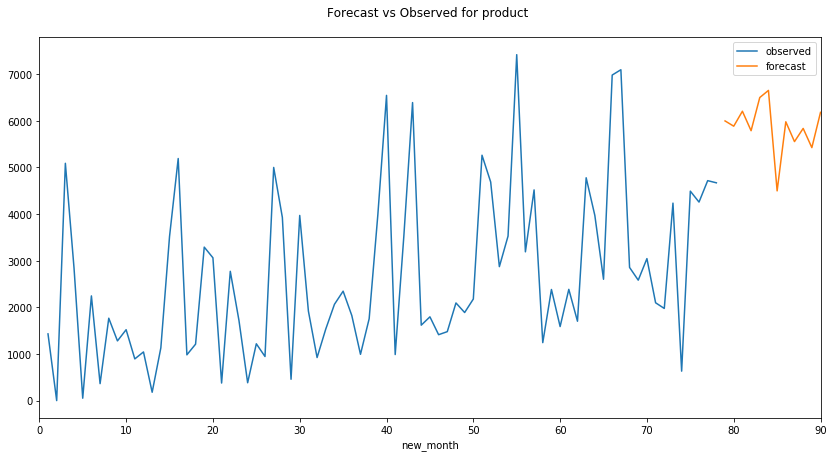

In [82]:
#Forecast for product 683 
Forecast()

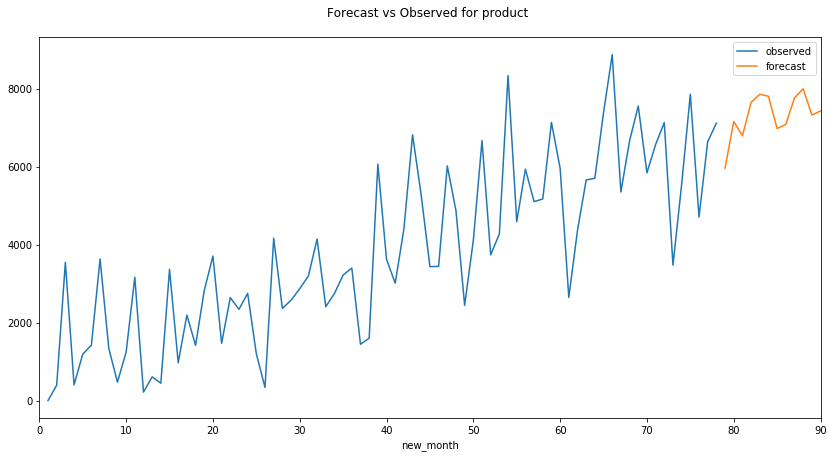

In [83]:
#Forecast for product 99444
Forecast(99444)

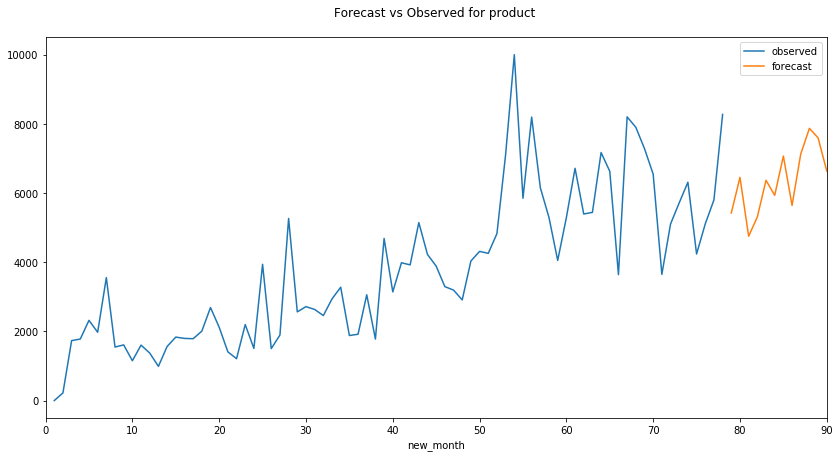

In [84]:
#Forecast for product 74321
Forecast(74321)

In [85]:
print("My program took", time.time() - start_time, "to run.")

My program took 15.901275396347046 to run.


In [86]:
forecasted_df.to_excel(r'C:\Users\mateu\Desktop\forecasted.xlsx')